In [34]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [35]:
## Reading train and test files

In [36]:
all_train_df = pd.read_csv("train.csv")
all_test_df = pd.read_csv("test.csv")

In [37]:
## feature names from the dataset

In [38]:
print (all_test_df.columns)

Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')


In [39]:
## extract labels and drop irrelevant features

In [40]:
all_train_df = all_train_df.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)
#all_test_df = all_test_df.drop(['PassengerId','Name','Cabin','Ticket'])

In [41]:
## drop missing values

In [42]:
all_train_df = all_train_df.dropna()

In [43]:
labels = pd.DataFrame(all_train_df['Survived'])
all_train_df = all_train_df.drop(['Survived'],axis=1)

In [44]:
## final shape of preprocessed training set

In [45]:
print (all_train_df.shape)

(712, 7)


In [46]:
## encoding nominal features

In [47]:
sex_trans = { 'male':0,
       'female':1
      }

embarked_trans = { 'S':0,
                  'C':1,
                  'Q':2
                 }



In [48]:
all_train_df['Sex'] = all_train_df['Sex'].apply(lambda x : sex_trans[x])
all_train_df['Embarked'] = all_train_df['Embarked'].apply(lambda x : embarked_trans[x])

In [49]:
## standardization of features using StandardScalar

In [50]:
all_train_df = pd.DataFrame(StandardScaler().fit_transform(all_train_df.values),columns=['Pclass', 'Sex',
                                                                                         'Age',  'SibSp',  'Parch'
                                                                                         ,'Fare',  'Embarked'])

In [51]:
## Feature Boxplot

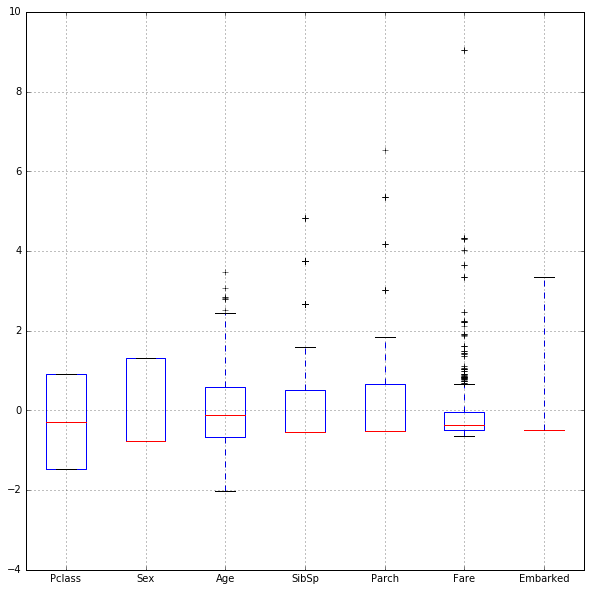

In [52]:
plt.figure(figsize=(10,10))
all_train_df.boxplot(return_type='axes')
plt.show()

In [53]:
## Summary description of our features

In [54]:
all_train_df.describe()

Pclass           Sex           Age         SibSp         Parch  \
count  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02   
mean  -1.587369e-16 -5.083325e-17  2.584933e-16  4.216353e-16 -1.372186e-17   
std    1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00   
min   -1.482983e+00 -7.561375e-01 -2.017717e+00 -5.527137e-01 -5.067874e-01   
25%   -1.482983e+00 -7.561375e-01 -6.657639e-01 -5.527137e-01 -5.067874e-01   
50%   -2.871914e-01 -7.561375e-01 -1.133826e-01 -5.527137e-01 -5.067874e-01   
75%    9.085997e-01  1.322511e+00  5.770939e-01  5.225108e-01  6.647471e-01   
max    9.085997e-01  1.322511e+00  3.477095e+00  4.823409e+00  6.522419e+00   

               Fare      Embarked  
count  7.120000e+02  7.120000e+02  
mean  -6.221615e-17 -1.640386e-16  
std    1.000703e+00  1.000703e+00  
min   -6.534272e-01 -5.012257e-01  
25%   -5.012575e-01 -5.012257e-01  
50%   -3.576726e-01 -5.012257e-01  
75%   -2.962586e-02 -5.012257e-01  
max    9.031168e+00  3.336115e+00

In [55]:
## label distribution

In [56]:
label_distribution = labels.groupby('Survived')
label_distribution['Survived'].count()

Survived
0    424
1    288
Name: Survived, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1082ce490>], dtype=object)

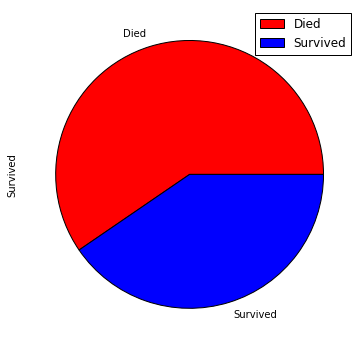

In [57]:
pie = pd.DataFrame(label_distribution['Survived'].count())
pie.plot(kind='pie',figsize=(6,6),subplots=True,labels=['Died','Survived'],colors=['r','b'])

In [58]:
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

In [59]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB,MultinomialNB
from sklearn import linear_model

from sklearn.neighbors import KNeighborsClassifier


import itertools
lb = pd.DataFrame(labels['Survived'].values)
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


def findsubsets(S,m):
    return set(itertools.combinations(S, m))

bestaccuracy=0
model_accuracy = pd.DataFrame()
mcount=0

models = {"DecisionTrees": tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_depth = 7),
          "RandomForest": RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=1, random_state=20160121)
         }

for name,model in models.items():
    print ("\nThe learning method is ",name)
    print("\n")
    bestaccuracy = 0
    for i in range(1,8):
        for attr in findsubsets(features,i):
            tr_df = all_train_df[list(attr)]
            stratified = StratifiedKFold(lb[0], n_folds=10,random_state=20160121, shuffle=True)
            print ("The selected features are ",(list(attr)))
            results_df = pd.DataFrame()
            foldnum=0
            for train,test in stratified:
                [data_tr,data_va,labels_tr,labels_va] = folds_to_split(tr_df,labels,train,test)

                model = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_depth = 7)
                model.fit(data_tr, labels_tr.values.ravel())
                score = model.score(data_va.values, labels_va.values.ravel())
                
                results_df.loc[foldnum,'accuracy'] = score 
                
                foldnum=foldnum+1
            print (results_df.mean())
            if (bestaccuracy < (results_df['accuracy'].mean())):
                bestaccuracy = results_df['accuracy'].mean()
                bestmodel = name
                bestfeatures = attr
    model_accuracy.loc[mcount,'accuracy'] = bestaccuracy
    model_accuracy.loc[mcount,'model'] = bestmodel
    model_accuracy.loc[mcount,'features'] = ' '.join(bestfeatures)
    mcount=mcount+1              

('\nThe learning method is ', 'RandomForest')


('The selected features are ', ['Sex'])
accuracy    0.779384
dtype: float64
('The selected features are ', ['SibSp'])
accuracy    0.610648
dtype: float64
('The selected features are ', ['Fare'])
accuracy    0.640544
dtype: float64
('The selected features are ', ['Age'])
accuracy    0.609456
dtype: float64
('The selected features are ', ['Embarked'])
accuracy    0.634989
dtype: float64
('The selected features are ', ['Parch'])
accuracy    0.624813
dtype: float64
('The selected features are ', ['Pclass'])
accuracy    0.674271
dtype: float64
('The selected features are ', ['Sex', 'Age'])
accuracy    0.775255
dtype: float64
('The selected features are ', ['Pclass', 'Age'])
accuracy    0.699509
dtype: float64
('The selected features are ', ['Parch', 'Fare'])
accuracy    0.686594
dtype: float64
('The selected features are ', ['Age', 'Embarked'])
accuracy    0.634929
dtype: float64
('The selected features are ', ['Sex', 'Fare'])
accuracy    0.78

In [60]:
print ("Following are the best results for each model\n", model_accuracy)


('Following are the best results for each model\n',    accuracy          model                  features
0  0.803468   RandomForest  Sex Age SibSp Parch Fare
1  0.803468  DecisionTrees  Sex Age SibSp Parch Fare)


In [61]:
# # Different params

# from sklearn import tree
# from sklearn.cross_validation import StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# import itertools

# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


# def findsubsets(S,m):
#     return set(itertools.combinations(S, m))

# bestaccuracy=0
# model_accuracy = pd.DataFrame()
# mcount=0

# all_attributes = {
#     'max_depth': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
#     'max_leaf_nodes': {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
#     'criterion': {'gini'},
#     'min_samples_leaf': {2, 5, 10, 20, 30, 40, 50, 100, 110, 120, 130}
#     }


# f = open('best_param.txt', 'a')

# for i in range(1,8):

#     for attr in findsubsets(features, i):

#         tr_df = all_train_df[list(attr)]
#         stratified = StratifiedKFold(np.reshape(labels.values,[labels.shape[0],]), n_folds=10, random_state=20160121, shuffle=True)

#         attribute_string = str(("The selected features are ", (list(attr), "\n")))
#         print ("The selected features are ",(list(attr)))
#         results_df = pd.DataFrame()
#         foldnum=0
        
#         for train,test in stratified:

#             [data_tr, data_va, labels_tr, labels_va] = folds_to_split(tr_df, labels, train, test)

#             for param in all_attributes.keys():
                
#                 for value in all_attributes[param]:
                    
#                     accuracy = 0

#                     if param == 'max_depth':
#                         dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_depth = value)

#                     elif param == 'max_leaf_nodes':
#                         dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', max_leaf_nodes = value)

#                     elif param == 'min_samples_leaf':
#                         dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini', min_samples_leaf = value)

#                     elif param == 'criterion':
#                         dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='gini')

                    
#                     dtree.fit(data_tr, labels_tr.values.ravel())
#                     accuracy = dtree.score(data_va.values, labels_va.values.ravel())              
#                     output_text =  str(param +  ", Val: " + str(value) + " Score: " + str(score) + "\n")
        
#                     f.write(attribute_string)
#                     f.write(output_text)
# #                     open_file_object.writerows(zip(ids, output))

        
#                     results_df.loc[foldnum,'accuracy'] = score
#                     foldnum=foldnum+1
        
    
# predictions_file.close()
# print ('Done.')

In [62]:
print ("Following are the best results for each model\n", model_accuracy)

('Following are the best results for each model\n',    accuracy          model                  features
0  0.803468   RandomForest  Sex Age SibSp Parch Fare
1  0.803468  DecisionTrees  Sex Age SibSp Parch Fare)


In [63]:
ids = all_test_df['PassengerId']
all_test_df = all_test_df.drop(['PassengerId','Name','Cabin','Ticket'],axis=1)

In [64]:
all_test_df['Sex'] = all_test_df['Sex'].apply(lambda x : sex_trans[x])
all_test_df['Embarked'] = all_test_df['Embarked'].apply(lambda x : embarked_trans[x])

In [65]:
pd.options.display.max_rows = 1000
age_mean = all_test_df['Age'].mean()
all_test_df.loc[all_test_df['Age'].isnull(),'Age']=age_mean
fare_mean = all_test_df.groupby('Pclass')['Fare'].mean()
all_test_df.loc[all_test_df['Fare'].isnull(),'Fare']=fare_mean[3]

In [66]:
all_test_df = pd.DataFrame(StandardScaler().fit_transform(all_test_df.values),columns=['Pclass', 'Sex',
                                                                                         'Age',  'SibSp',  'Parch'
                                                                                         ,'Fare',  'Embarked'])



In [67]:
from sklearn import tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools

model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=1, random_state=20160121)
model.fit(tr_df[['Pclass','Sex','Age', 'SibSp', 'Embarked']], lb[0])
output = model.predict(all_test_df[['Pclass','Sex','Age', 'SibSp', 'Embarked']].values)

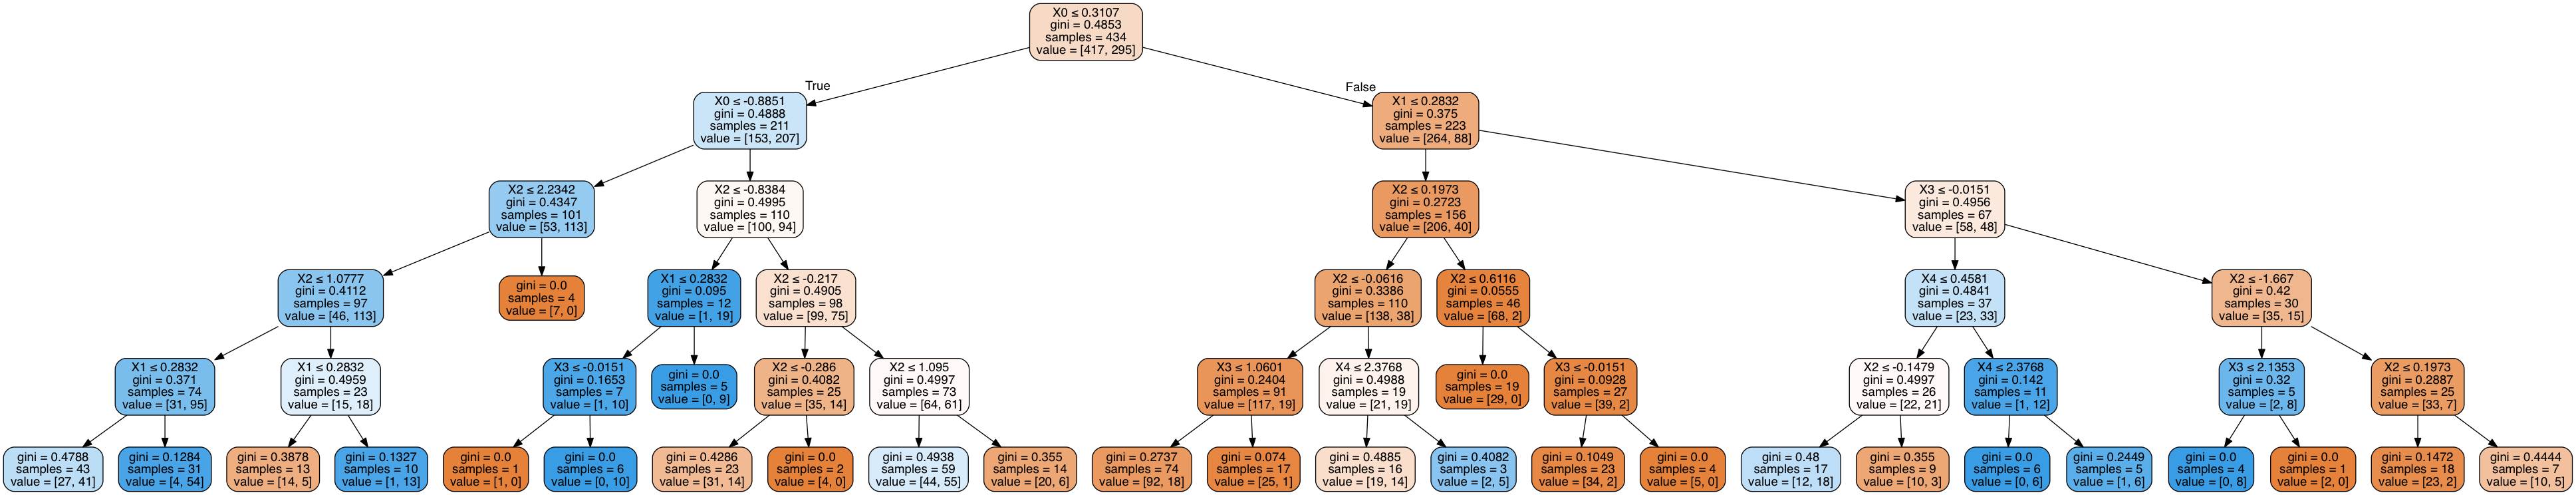

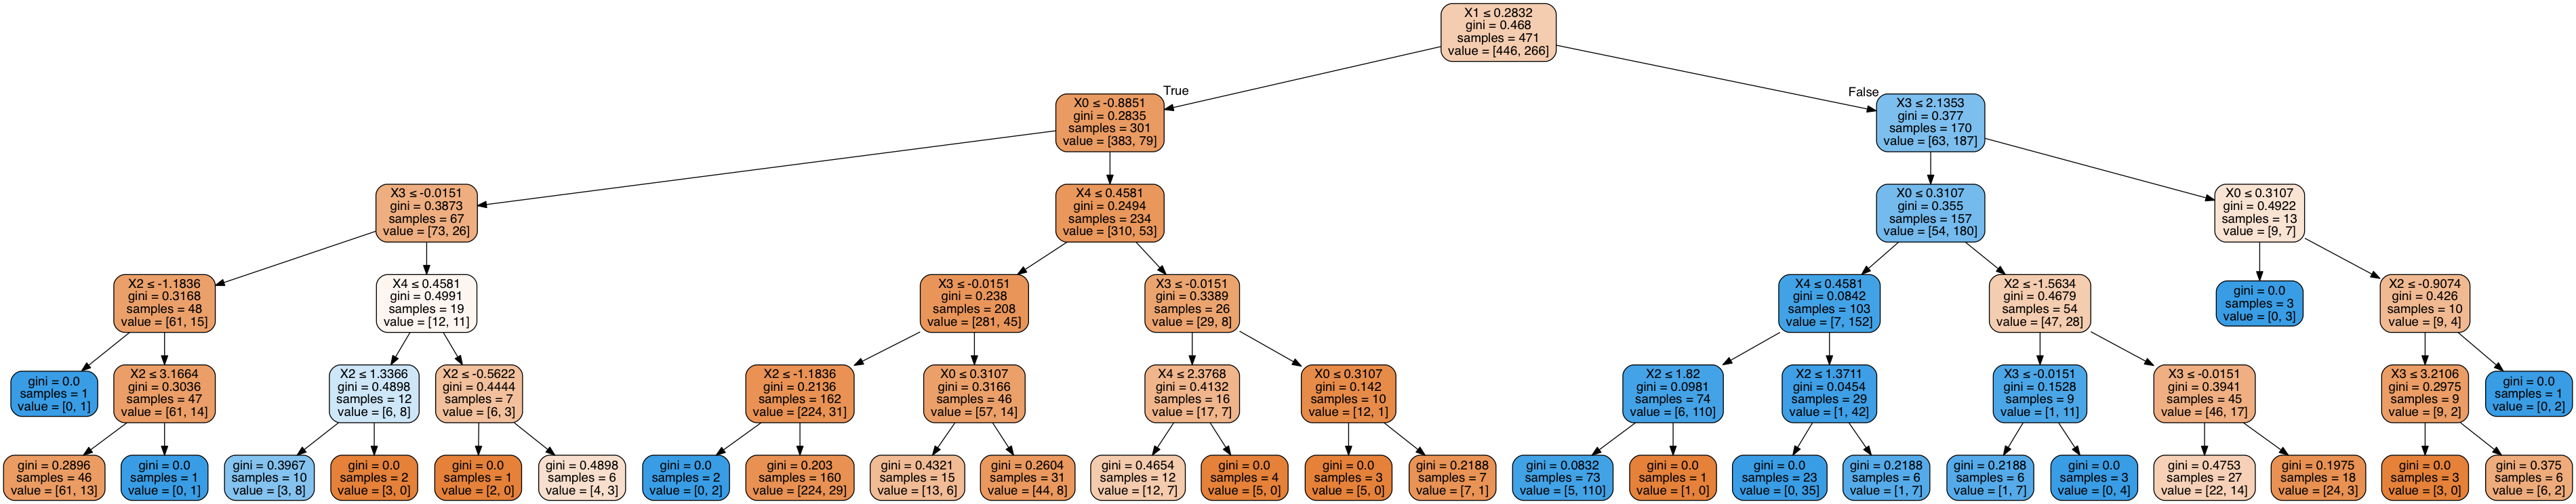

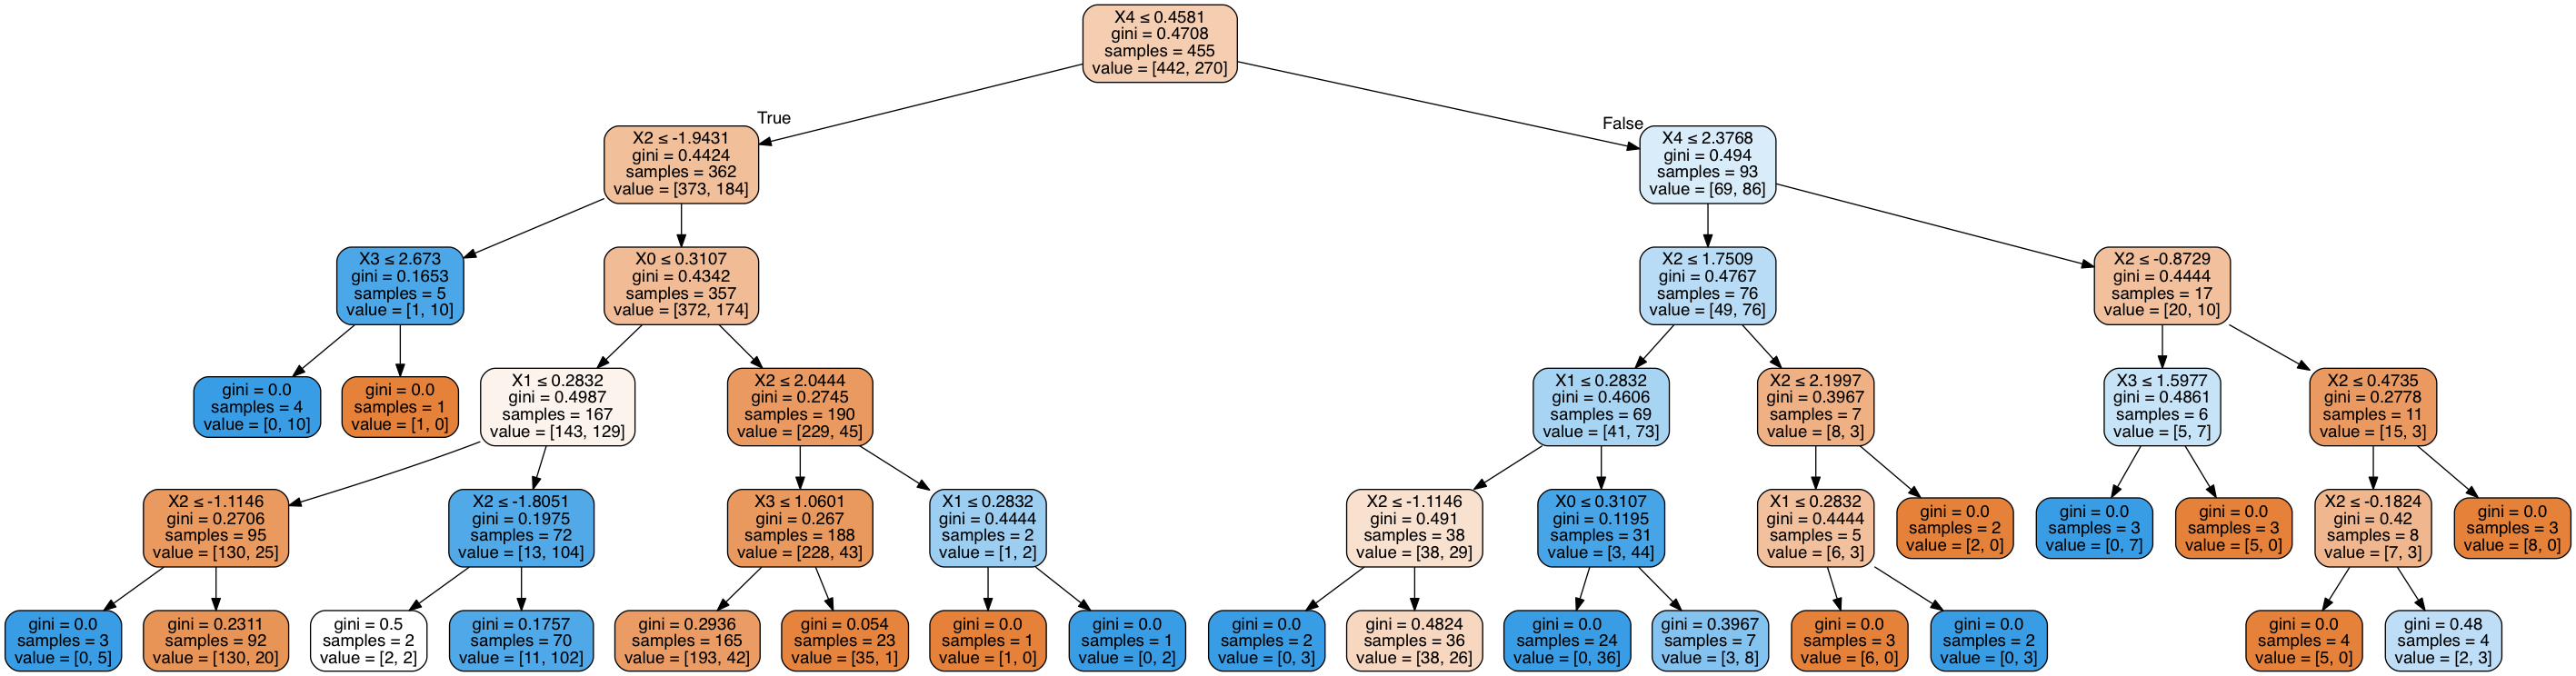

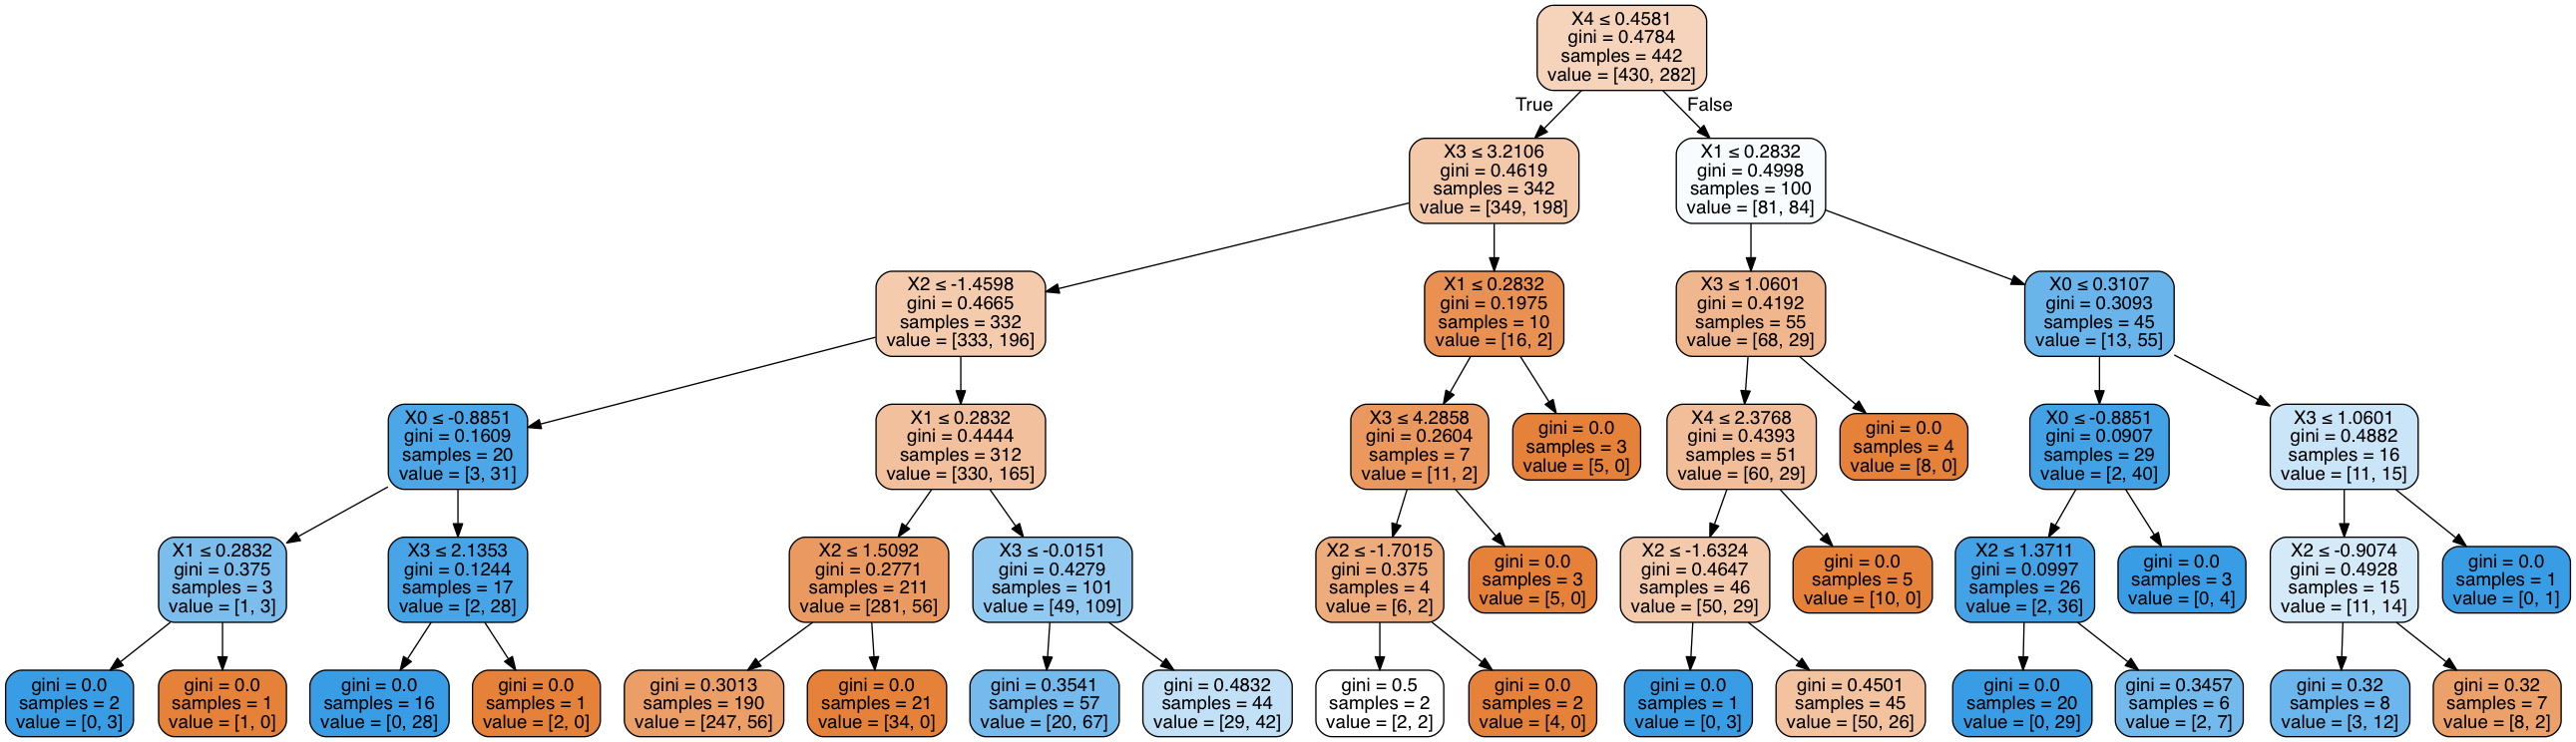

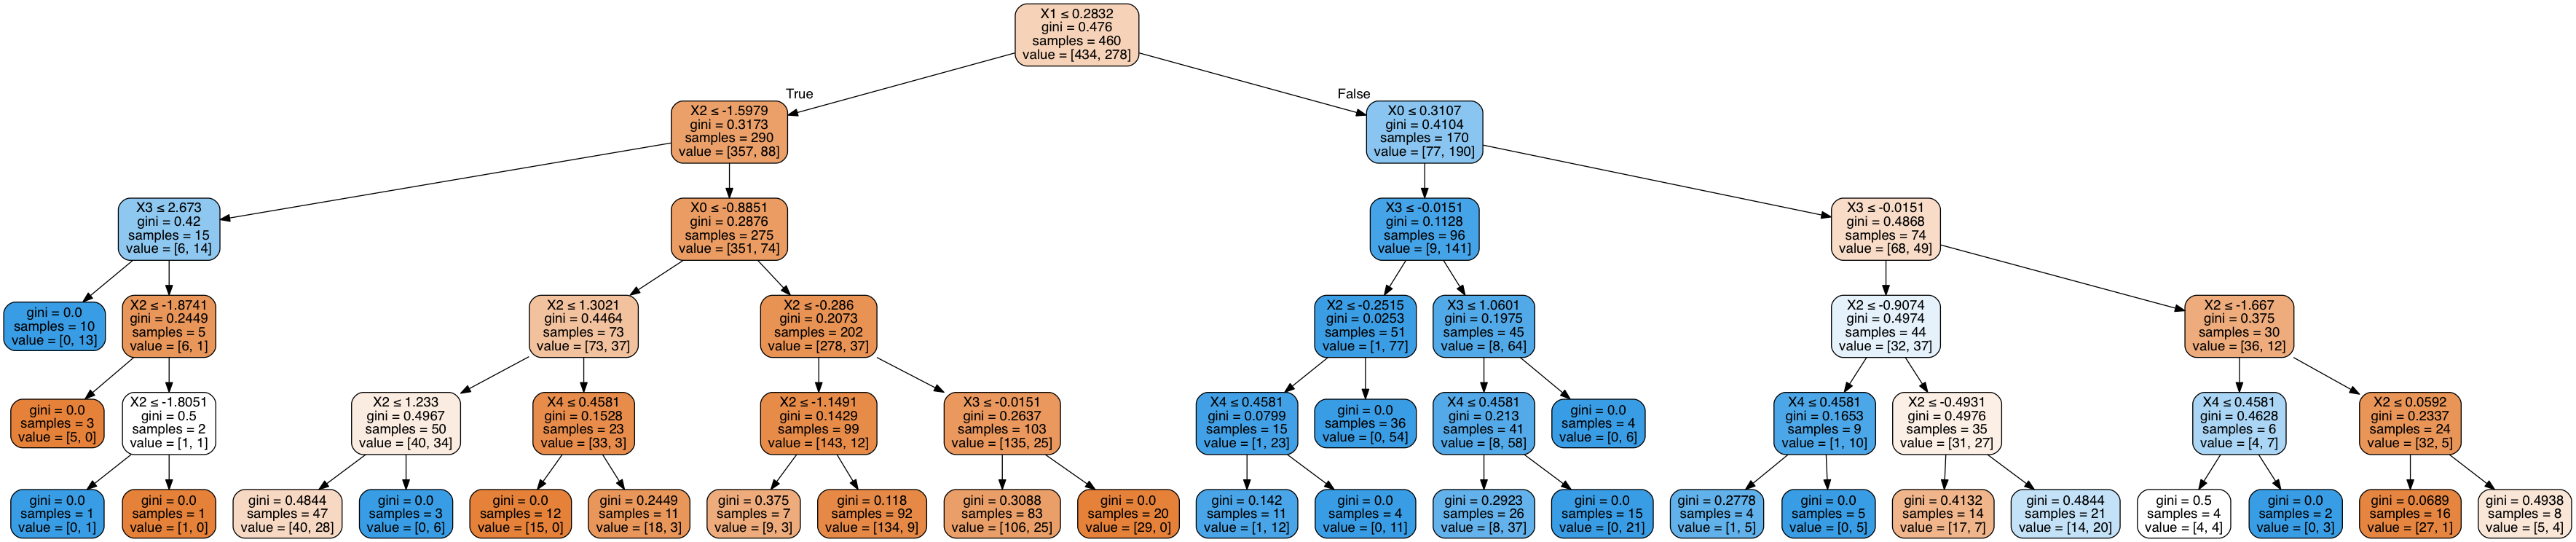

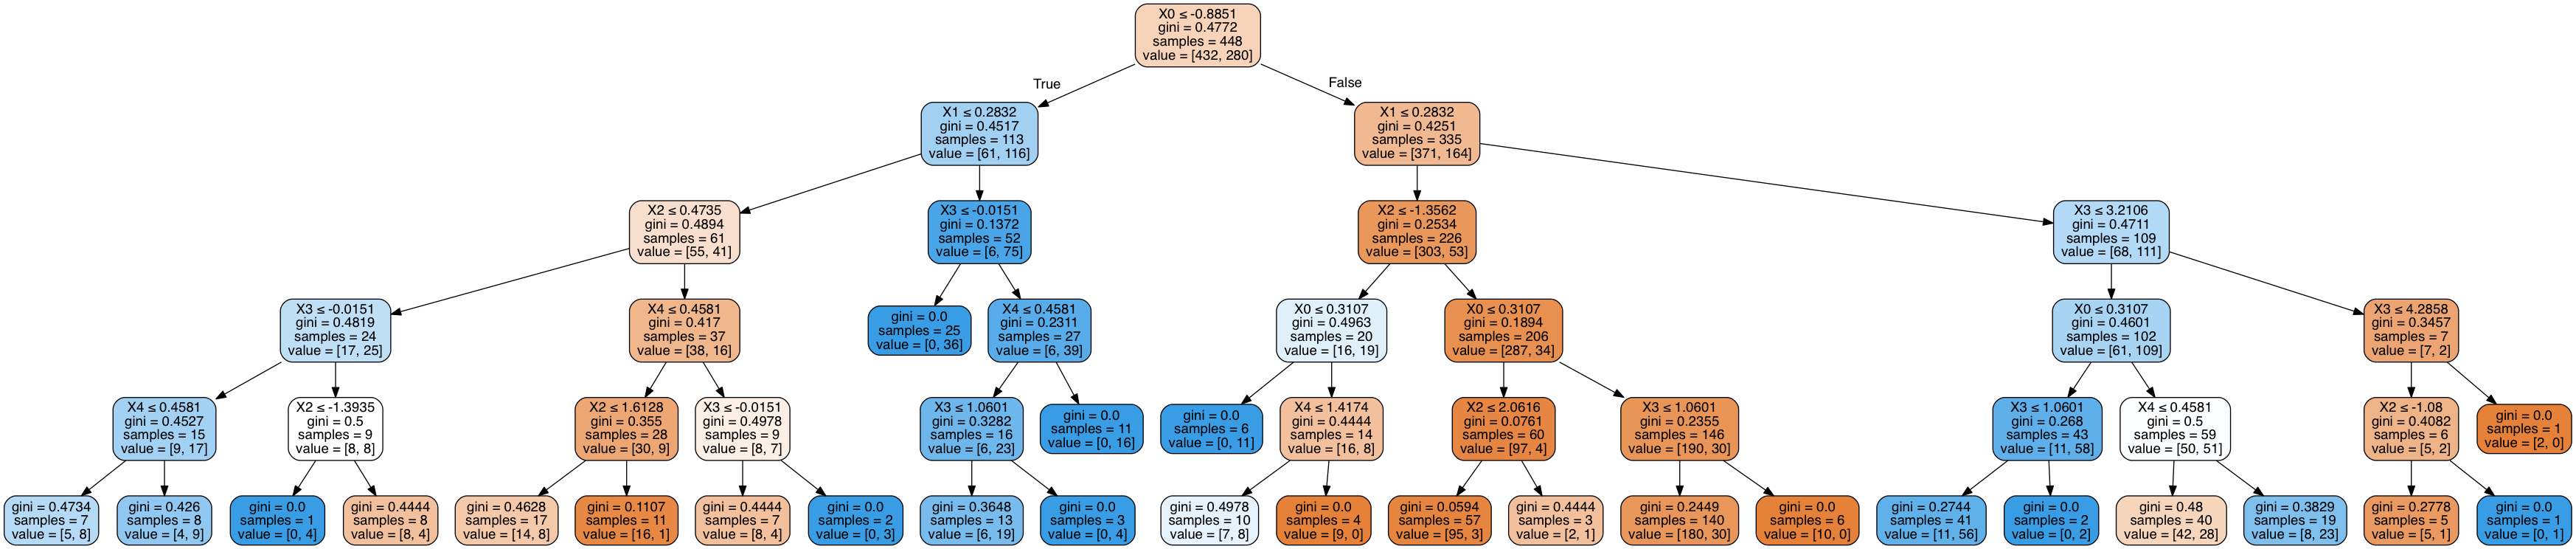

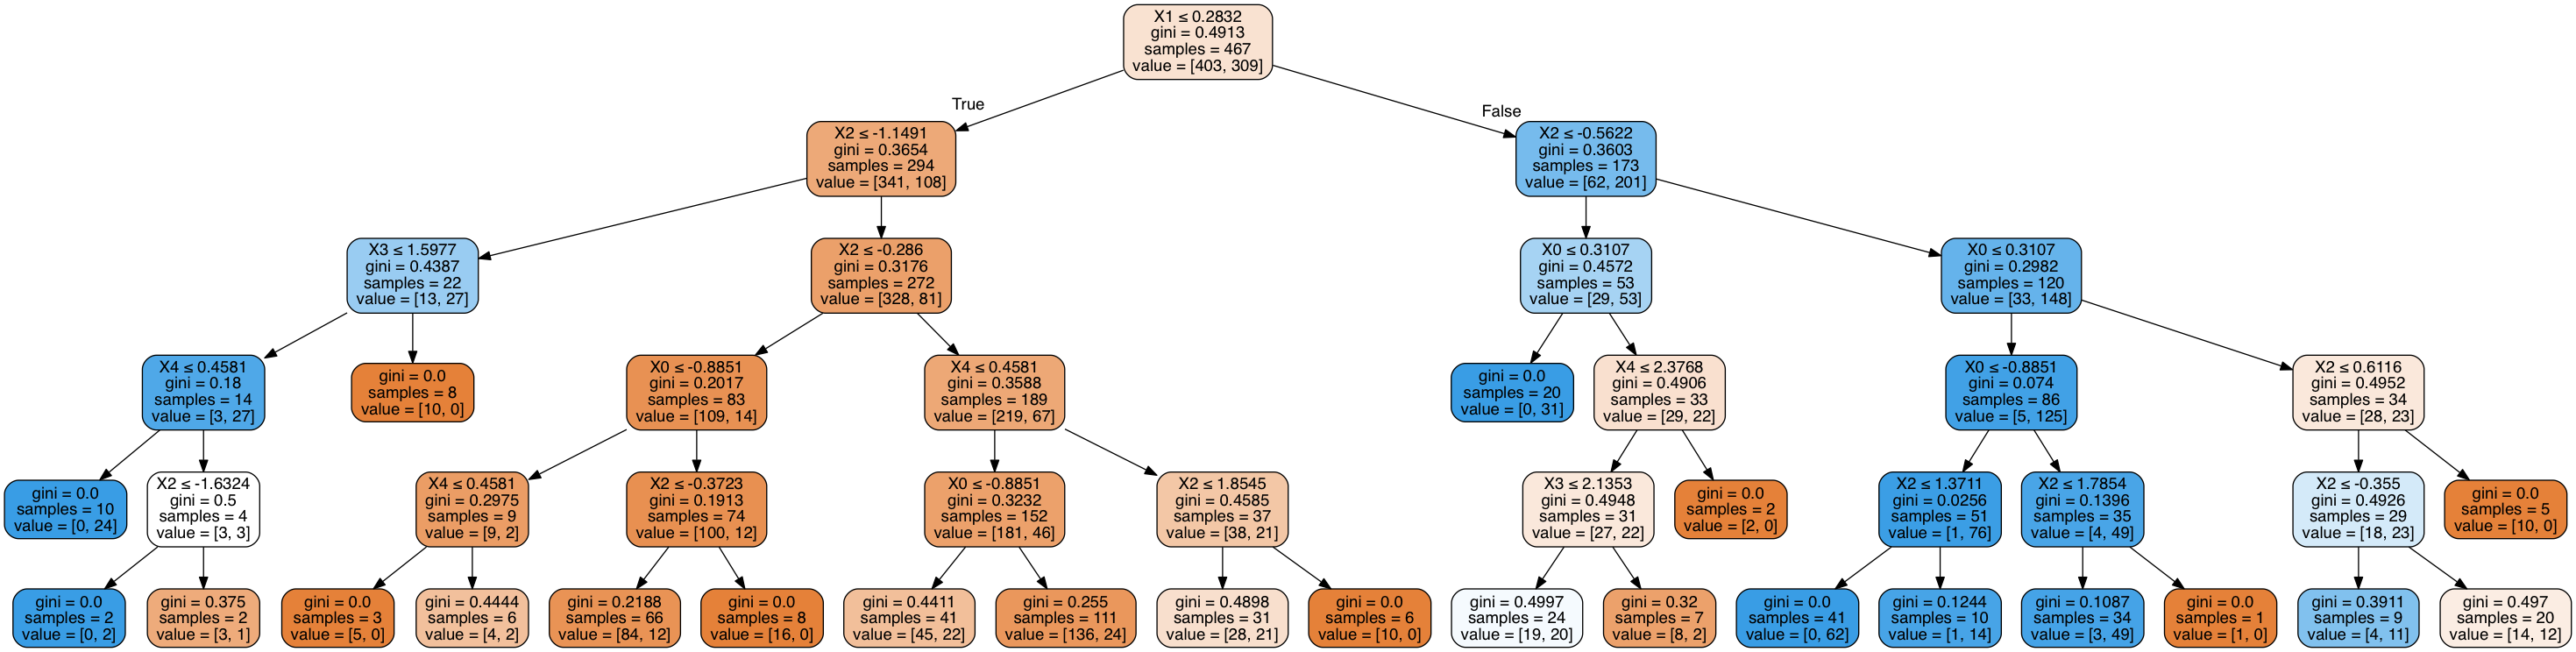

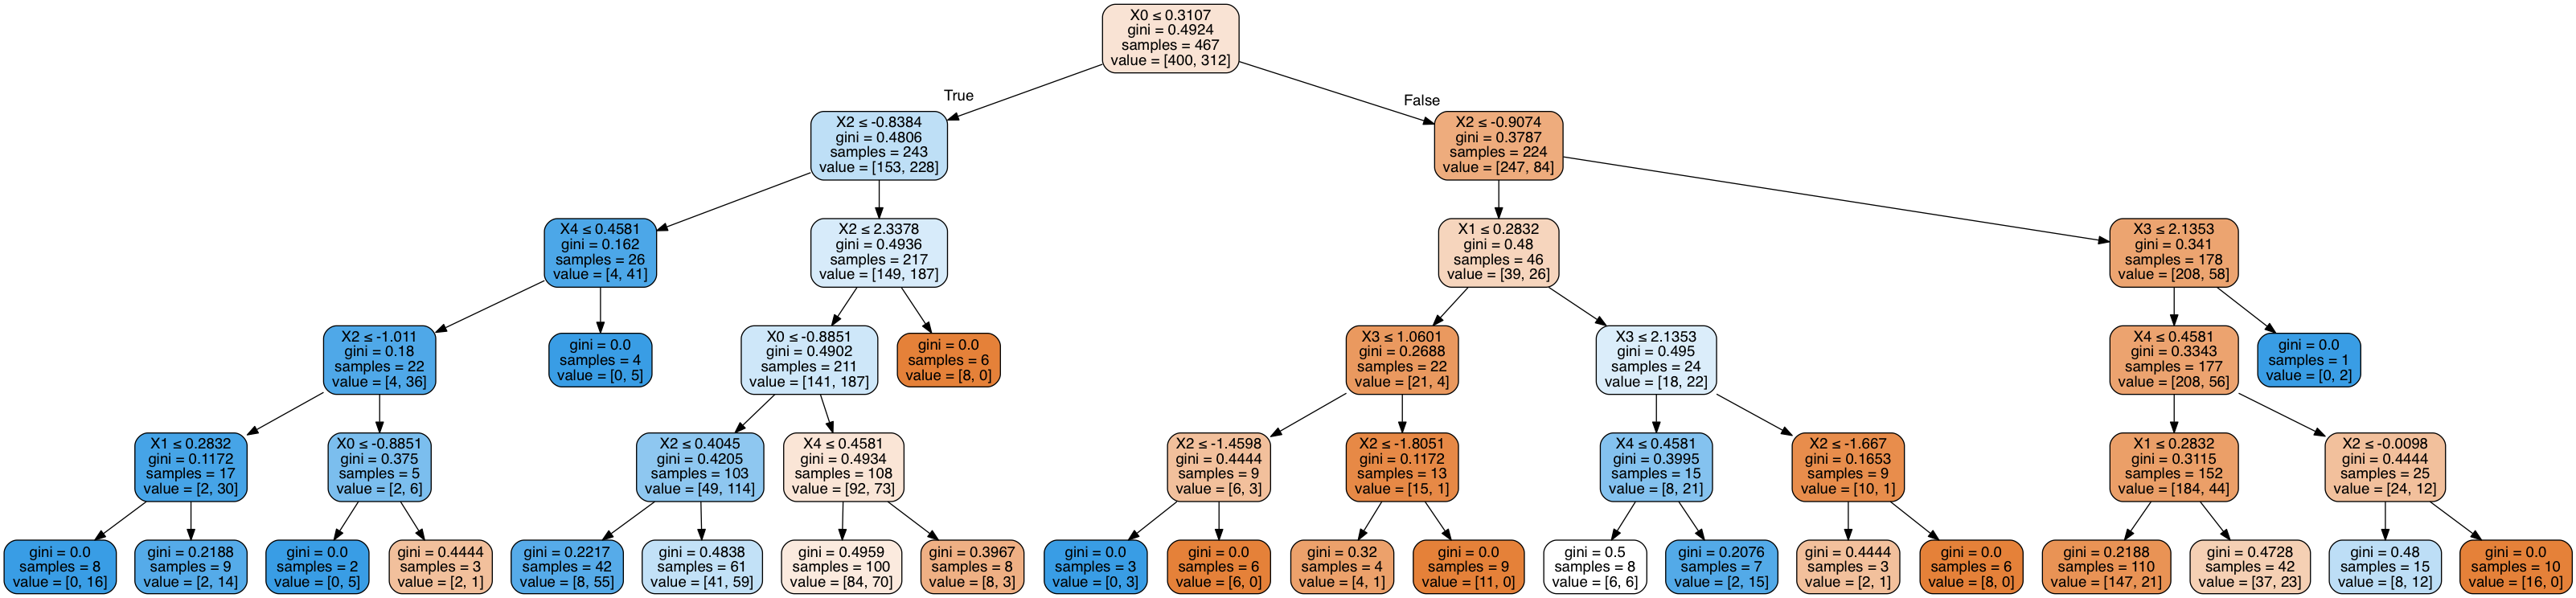

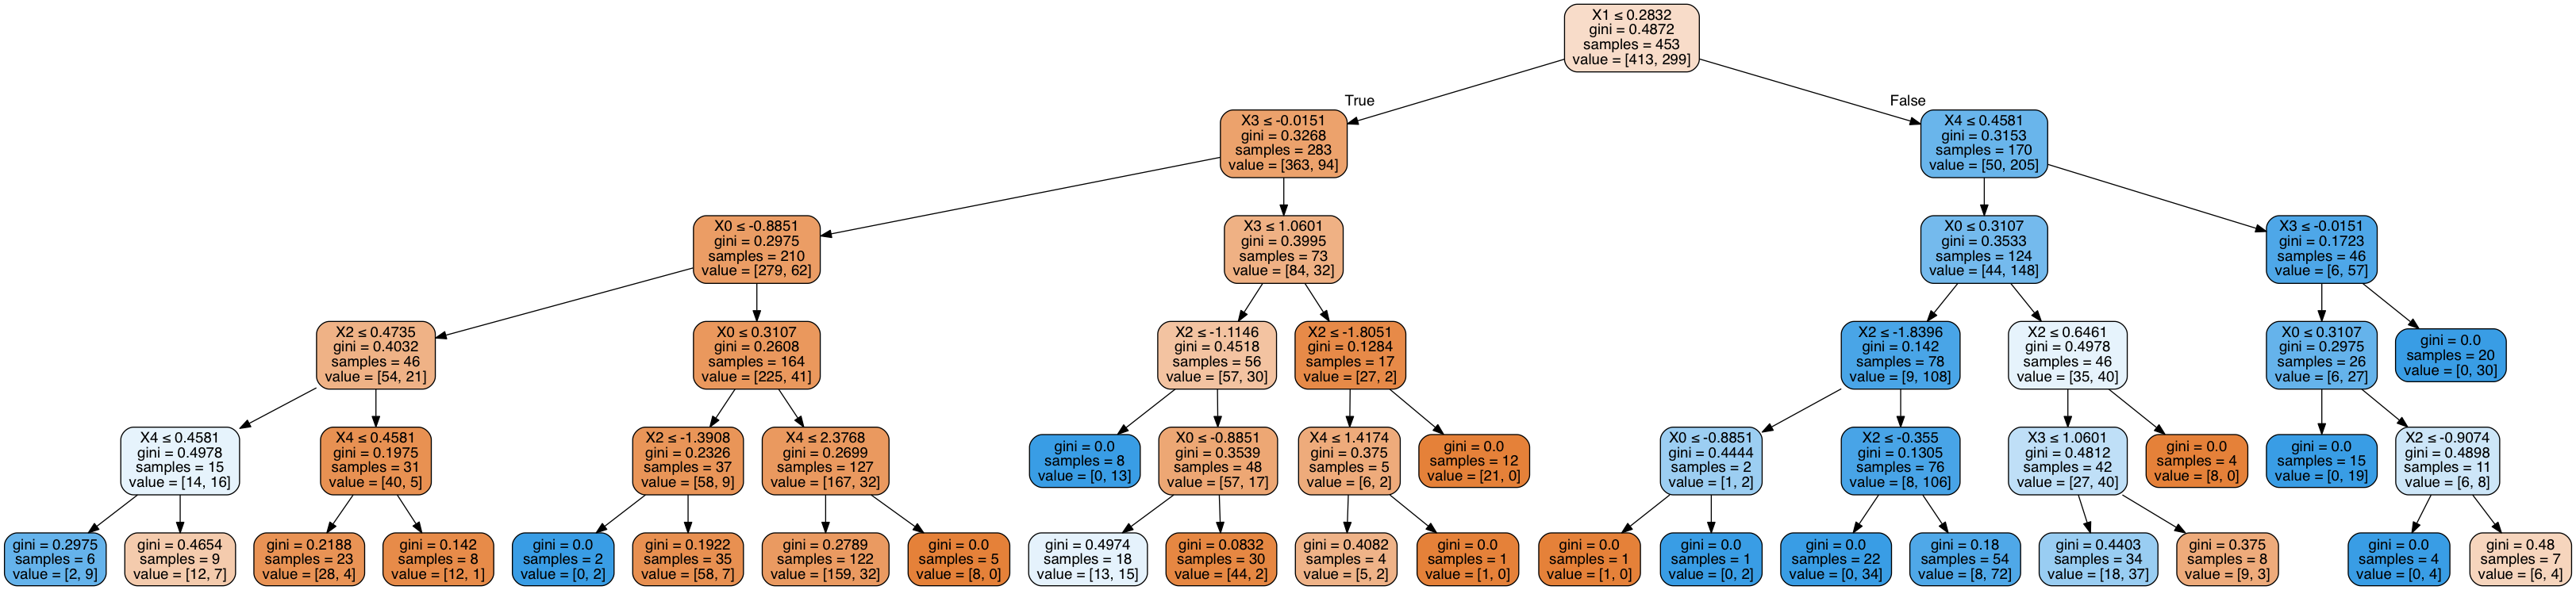

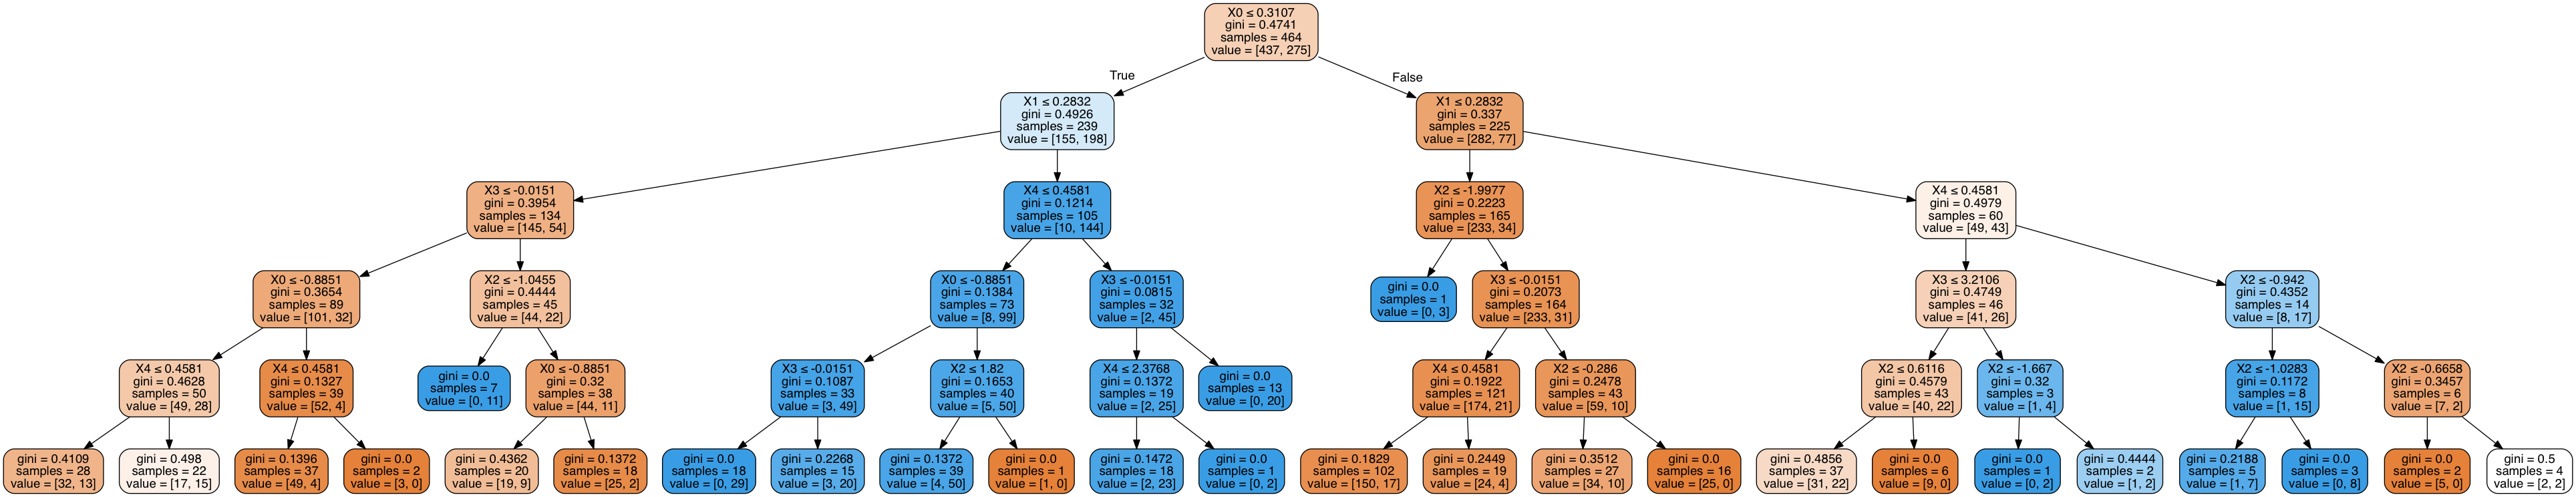

In [68]:
from IPython.display import Image, display
from sklearn.externals.six import StringIO
import pydot 

for dtree in model.estimators_:

    dot_data = StringIO() 
    tree.export_graphviz(dtree, out_file=dot_data,  
                     filled=True, rounded=True,  
                     special_characters=True)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

In [69]:
predictions_file = open("rf.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.


In [70]:
model = DecisionTreeClassifier(random_state=20160121, max_depth = 5, max_leaf_nodes = 9, min_samples_leaf = 2)
model.fit(tr_df[['Sex','Age', 'SibSp', 'Parch']], lb[0])
output = model.predict(all_test_df[['Sex','Age', 'SibSp', 'Parch']].values)

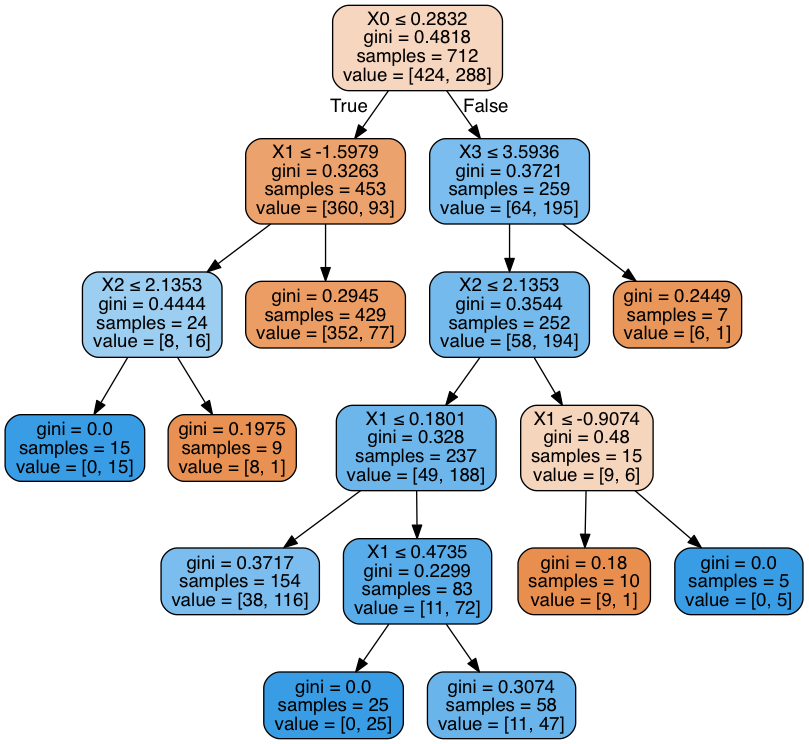

In [71]:
dot_data = StringIO() 
tree.export_graphviz(model, out_file=dot_data,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

In [72]:
predictions_file = open("dt.csv", "w")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print ('Done.')

Done.
